In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation 
%matplotlib inline
import time, sys
from scipy.sparse import spdiags
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
import pickle
from scipy.io import savemat, loadmat
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# load weights and bias
file_name_AE="./model/AE_v2_swish.p"

AE = pickle.load(open(file_name_AE,'rb'))

en_w1=AE['en_w1']
en_b1=AE['en_b1']
en_w2=AE['en_w2']
de_w1=AE['de_w1']
de_w2=AE['de_w2']
de_w1T=AE['de_w1T']
de_w2T=AE['de_w2T']
de_w2_sp=AE['de_w2_sp']
de_w2T_sp=AE['de_w2T_sp']

m, M2 = de_w2.shape
f = de_w1.shape[1]

In [3]:
def sigmoid_np(input):
    return (1.0/(1.0+np.exp(-input))).astype('float32')

def decoder_np_forward(x):
    z1 = de_w1.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = de_w2.dot(a1)  
    return y

def decoder_np_forward_backward(x):
    z1 = de_w1.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = de_w2.dot(a1)

    dout = de_w1T
    dout = (s1 + a1*(1-s1))*dout
    dydxT = dout.dot(de_w2T)   
    return y,dydxT.T

def decoder_sp_forward(x):
    z1 = de_w1.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = sp.csr_matrix.dot(de_w2_sp,a1)
    return y

def decoder_sp_forward_backward(x):
    z1 = de_w1.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = sp.csr_matrix.dot(de_w2_sp,a1)

    dout = de_w1T
    dout = (s1 + a1*(1-s1))*dout
    dydxT = sp.csr_matrix.dot(dout,de_w2T_sp)
    return y,dydxT.T

In [4]:
def DEIM(phi_f, nfeval=None):
    
    ninf=np.NINF
    n,m=np.shape(phi_f)
    if nfeval==None:
        nfeval=m
        
    if nfeval<m:
        print("ill-posed\n")
        print("set # sampling equal to # modes")
        nfeval=m
        
    div,mod=np.divmod(nfeval,m)
    
    I=np.eye(n)
    
    l=0
    ns=div+mod
    u=np.reshape(phi_f[:,l],(n,1))
    p=np.argsort(-np.abs(u),axis=0,kind='stable')[:ns]
#     p=np.argmax(np.abs(u)) # when ns=1
    ep=np.reshape(I[:,p],(n,ns))
    U=u
    P=ep

    ns=div
    for l in range(1,m):
        u=np.reshape(phi_f[:,l],(n,1))
        PT=np.transpose(P)
        c=np.linalg.lstsq(PT@U,PT@u,rcond=None)[0]
        r=np.abs(u-U@c)
        r[p]=ninf
        p=np.append(p,np.argsort(-r,axis=0,kind='stable')[:ns]) # ns!=1
        ep=np.reshape(I[:,p[-ns:]],(n,ns))
        U=np.concatenate((U,u),axis=1)
        P=np.concatenate((P,ep),axis=1)
        
    return p

In [5]:
def residual_lspg_hr(uwn_z,g,z0_ind,z1_ind,c):
    
    # g is subnet of g
    # Jg is subnet of Jg
    # z_union[z0_ind] gives z0, which is z
    # z_union[z1_ind] igves z1, which is z-1
    
    r = -uwn_z + g[z0_ind] + c*(g[z0_ind]**2 - g[z0_ind]*g[z1_ind])
    
    return r

def jacobian_lspg_hr(g,Jg,z0_ind,z1_ind,c):
    
    J = ((1.0 + c*(2*g[z0_ind] - g[z1_ind]))*Jg[z0_ind].T).T + (-c*g[z0_ind]*Jg[z1_ind].T).T
    
    return J

In [6]:
# load snapshot
# snapshot_full=pickle.load(open('./data/snapshot_full.p','rb'))
# DEIM_snapshot=snapshot_full[:,:-1]

# Do SVD
# Ur,Sr,VrT=np.linalg.svd(DEIM_snapshot.T,full_matrices=False)
# SVD={'Ur':Ur,'Sr':Sr,'VrT':VrT}
# pickle.dump(SVD,open('./model/NMROM_residual_basis.p','wb'))
SVD=pickle.load(open('./model/NMROM_residual_basis.p','rb'))
Ur=SVD['Ur']
# plt.figure()
# plt.semilogy(Sr)
# plt.show()


amp=0.6

DEIM test time elapsed: 210.29001593589783 sec

Best case is
# of residual basis: 46
# of residual sampes: 48

Time elapsed: 0.6040000915527344 sec
average relative error: 3.5312327614843007%
maximum relative error: 4.99653161577427%


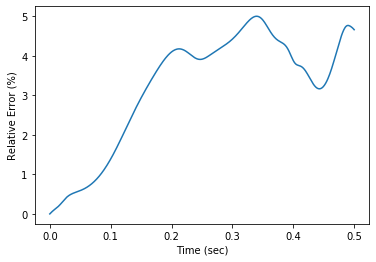


------------------------------------------------------------------------

amp=0.62

DEIM test time elapsed: 191.7600293159485 sec

Best case is
# of residual basis: 37
# of residual sampes: 39

Time elapsed: 0.5990021228790283 sec
average relative error: 2.687665040645839%
maximum relative error: 4.251551482840108%


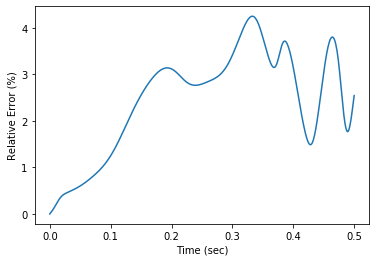


------------------------------------------------------------------------

amp=0.64

DEIM test time elapsed: 192.64669156074524 sec

Best case is
# of residual basis: 37
# of residual sampes: 39

Time elapsed: 0.6200006008148193 sec
average relative error: 2.4852969089209047%
maximum relative error: 3.864721735342268%


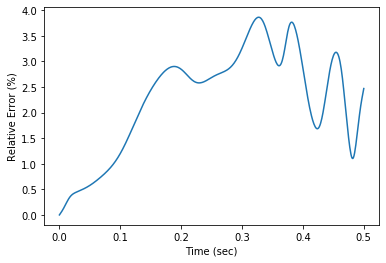


------------------------------------------------------------------------

amp=0.66

DEIM test time elapsed: 196.88010358810425 sec

Best case is
# of residual basis: 44
# of residual sampes: 46

Time elapsed: 0.6710047721862793 sec
average relative error: 2.6721970674737765%
maximum relative error: 3.770418574195017%


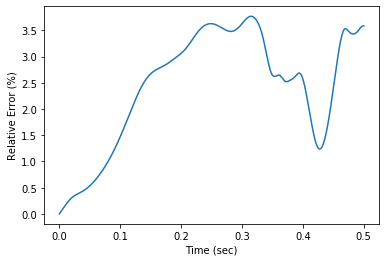


------------------------------------------------------------------------

amp=0.68

DEIM test time elapsed: 200.98721957206726 sec

Best case is
# of residual basis: 42
# of residual sampes: 44

Time elapsed: 0.6220018863677979 sec
average relative error: 2.2128948736671292%
maximum relative error: 3.4215989911764626%


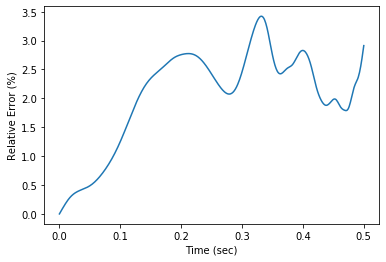


------------------------------------------------------------------------

amp=0.7

DEIM test time elapsed: 198.7110025882721 sec

Best case is
# of residual basis: 42
# of residual sampes: 44

Time elapsed: 0.6199986934661865 sec
average relative error: 1.9483062817092551%
maximum relative error: 2.945870919921471%


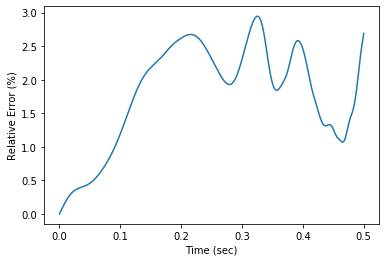


------------------------------------------------------------------------

amp=0.72

DEIM test time elapsed: 194.98653626441956 sec

Best case is
# of residual basis: 42
# of residual sampes: 44

Time elapsed: 0.5930020809173584 sec
average relative error: 1.7784453609319213%
maximum relative error: 2.7219748051154213%


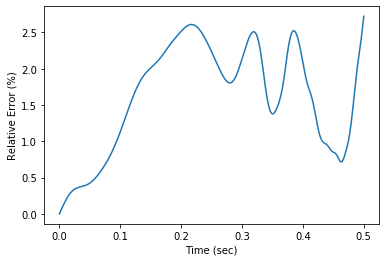


------------------------------------------------------------------------

amp=0.74

DEIM test time elapsed: 196.0888750553131 sec

Best case is
# of residual basis: 42
# of residual sampes: 44

Time elapsed: 0.630002498626709 sec
average relative error: 1.7186672991936343%
maximum relative error: 2.8893794954693344%


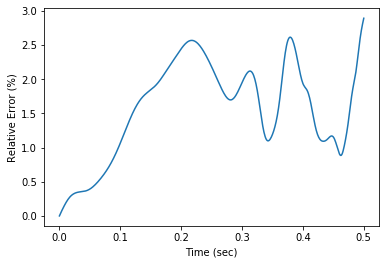


------------------------------------------------------------------------

amp=0.76

DEIM test time elapsed: 199.11531162261963 sec

Best case is
# of residual basis: 43
# of residual sampes: 45

Time elapsed: 0.6710102558135986 sec
average relative error: 1.6343748430661842%
maximum relative error: 2.7434540983694955%


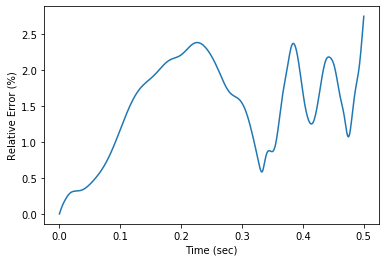


------------------------------------------------------------------------

amp=0.78

DEIM test time elapsed: 202.8997347354889 sec

Best case is
# of residual basis: 36
# of residual sampes: 45

Time elapsed: 0.6536586284637451 sec
average relative error: 1.2862590294933502%
maximum relative error: 2.467262614634075%


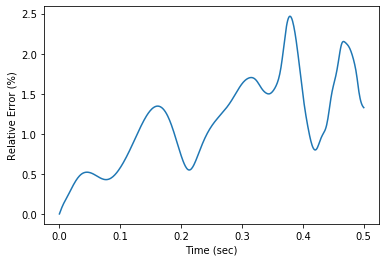


------------------------------------------------------------------------


In [7]:
ampArr = np.array([0.6,0.62,0.64,0.66,0.68,0.70,0.72,0.74,0.76,0.78,0.8,0.82,0.84,0.86,0.88,0.9,0.92,0.94,0.96,0.98,1.0,\
                   1.02,1.04,1.06,1.08,1.1,1.12,1.14,1.16,1.18,1.2])
num_amp=ampArr.shape[0]
resultArr=np.zeros((num_amp,6))

for ii in range(num_amp):
    # load FOM solution
    amp=ampArr[ii]
    print()
    print('amp={}'.format(amp))
    file_name_FOM="./data/FOM_amp_{}.p".format(amp)
    u=pickle.load(open(file_name_FOM,'rb'))
    
    # set parameters
    width = 1.0

    convergence_threshold = 1.0e-5
    maxk = 4

    nx = 1001
    dx = 2.0 / (nx - 1)
    nt = 500
    dt = 0.5 / nt  

    c = dt/dx

    x = np.linspace(0, 2, nx)

    idxn1=np.zeros(nx-1,dtype='int')
    idxn1[1:]=np.arange(nx-2)
    idxn1[0]=nx-2

    u0 = np.copy(u[0])
    u_hat0=np.zeros(f,dtype='float32')
    
    # Find best residual basis dim. and # of samples
    DEIM_test_tstart=time.time()

    # choose # of DEIM basis and DEIM samples
    DEIM_min=30
    DEIM_max=50

    n_test=int((DEIM_max-DEIM_min)*(DEIM_max-DEIM_min+1)/2)
    # print('Total # of test: {}'.format(n_test))

    # save test results: [DEIM_basis, DEIM_samples, Time_elapsed, Max_rel_err]
    test_results=np.zeros((n_test,4))

    test_count=0
    for DEIM_basis in np.arange(DEIM_min,DEIM_max):
        for DEIM_samples in np.arange(DEIM_basis,DEIM_max):
            test_count+=1
    #         print()
    #         print('Test #{}'.format(test_count))
    #         print('-'*72)
    #         print('DEIM_basis: {}, DEIM_samples: {}'.format(DEIM_basis,DEIM_samples))

            try:
                # precompute
                phi_r=Ur[:,:DEIM_basis]
                z=DEIM(phi_r,DEIM_samples)
                ZT=np.eye(nx-1,dtype='float32')[z]
                Z=ZT.T
                precomp1=phi_r@np.linalg.pinv(ZT@phi_r)
                precomp=precomp1.T@precomp1

                # influential indices
                z_union=np.zeros((z.size,2),dtype='int')
                for i in range(z.size):
                    if z[i]==0:
                        z_union[i,0]=0
                        z_union[i,1]=nx-2
                    else:
                        z_union[i,0]=z[i]
                        z_union[i,1]=z[i]-1        
                z0=z_union[:,0]
                z1=z_union[:,1]

                z_union=np.unique(z_union.flatten())

                z_union0_ind=np.zeros(z0.size,dtype='int')
                z_union1_ind=np.zeros(z1.size,dtype='int')
                for i in range(z0.size):
                    z_union0_ind[i]=np.nonzero(np.isin(z_union,z0[i]))[0]
                    z_union1_ind[i]=np.nonzero(np.isin(z_union,z1[i]))[0]

                # Construct subnet
                class DecoderFC(nn.Module):

                    def __init__(self,):
                        super(DecoderFC, self).__init__()
                        self.fc1 = nn.Linear(f,M2,bias=False)
                        self.fc1.weight = nn.Parameter(torch.ones(de_w1.shape))
                #         self.fc1.weight = nn.Parameter(torch.tensor(de_w1))

                        self.fc2 = nn.Linear(M2,m,bias=False)
                        self.fc2.weight = nn.Parameter(torch.ones(de_w2.shape))
                #         self.fc2.weight = nn.Parameter(torch.tensor(de_w2))

                    def forward(self, x):
                        x = self.fc1(x)
                        x = self.fc2(x)
                        return x

                model = DecoderFC()

                x_in=torch.ones(f)
                y_out=model(x_in)

                p_hr=z_union

                upstream=torch.zeros_like(y_out)
                upstream[p_hr]=1.0

                y_out.backward(upstream)

                # masks for subnet
                w1_mask=model.fc1.weight.grad
                w2_mask=model.fc2.weight.grad

                # subnet sparse weight
                idx1=w1_mask.to_sparse()._indices()
                i1=idx1.numpy()[0]
                j1=idx1.numpy()[1]
                v1=de_w1[i1,j1]
                w1_sb_sp=sp.csr_matrix(sp.csr_matrix((v1,(i1,j1)),shape=w1_mask.shape).toarray())

                idx2=w2_mask.to_sparse()._indices()
                i2=idx2.numpy()[0]
                j2=idx2.numpy()[1]
                v2=de_w2[i2,j2]
                w2_sb_sp=sp.csr_matrix(sp.csr_matrix((v2,(i2,j2)),shape=w2_mask.shape).toarray())

                # subnet compressed weight
                i1,j1,v1=sp.find(w1_sb_sp)
                i1_unique,i1_inverse=np.unique(i1,return_inverse=True)
                i1_comp=np.arange(i1_unique.size)
                i1_comp=i1_comp[i1_inverse]
                j1_unique,j1_inverse=np.unique(j1,return_inverse=True)
                j1_comp=np.arange(j1_unique.size)
                j1_comp=j1_comp[j1_inverse]
                w1_sb_comp_sp=sp.csr_matrix((v1,(i1_comp,j1_comp)),shape=(i1_unique.size,j1_unique.size))

                i2,j2,v2=sp.find(w2_sb_sp)
                i2_unique,i2_inverse=np.unique(i2,return_inverse=True)
                i2_comp=np.arange(i2_unique.size)
                i2_comp=i2_comp[i2_inverse]
                j2_unique,j2_inverse=np.unique(j2,return_inverse=True)
                j2_comp=np.arange(j2_unique.size)
                j2_comp=j2_comp[j2_inverse]
                w2_sb_comp_sp=sp.csr_matrix((v2,(i2_comp,j2_comp)),shape=(i2_unique.size,j2_unique.size))

                w1_sb_comp_dense=w1_sb_comp_sp.toarray()
                w1_sb_comp_dense=w1_sb_comp_dense[j2_unique]
                w2_sb_comp_dense=w2_sb_comp_sp.toarray()

                w1_sb_comp_denseT=w1_sb_comp_dense.T
                w2_sb_comp_denseT=w2_sb_comp_dense.T

                # Using sparse matrix
                w2_sb_comp_sp=sp.csr_matrix(w2_sb_comp_dense,dtype='float32')
                w2_sb_comp_spT=sp.csr_matrix(w2_sb_comp_denseT,dtype='float32')

                def sigmoid_np(input):
                    return (1.0/(1.0+np.exp(-input))).astype('float32')

                def decoder_sb_np_forward(x):
                    z1 = w1_sb_comp_dense.dot(x)
                    s1 = sigmoid_np(z1)
                    a1 = z1*s1
                    y = w2_sb_comp_dense.dot(a1)  
                    return y

                def decoder_sb_np_forward_backward(x):
                    z1 = w1_sb_comp_dense.dot(x)
                    s1 = sigmoid_np(z1)
                    a1 = z1*s1
                    y = w2_sb_comp_dense.dot(a1) 

                    dout = w1_sb_comp_denseT
                    dout = (a1 + s1*(1-a1))*dout
                    dydxT = dout.dot(w2_sb_comp_denseT)
                    return y,dydxT.T

                def decoder_sb_sp_forward(x):
                    z1 = w1_sb_comp_dense.dot(x)
                    s1 = sigmoid_np(z1)
                    a1 = z1*s1
                    y = sp.csr_matrix.dot(w2_sb_comp_sp,a1)
                    return y

                def decoder_sb_sp_forward_backward(x):
                    z1 = w1_sb_comp_dense.dot(x)
                    s1 = sigmoid_np(z1)
                    a1 = z1*s1
                    y = sp.csr_matrix.dot(w2_sb_comp_sp,a1)

                    dout = w1_sb_comp_denseT
                    dout = (a1 + s1*(1-a1))*dout
                    dydxT = sp.csr_matrix.dot(dout,w2_sb_comp_spT)
                    return y,dydxT.T

                # Run NM-ROM-DEIM
                t_total_rom_hr_start=time.time()

                u_rom_lspg_hr = np.zeros((nt+1,nx),dtype='float32')
                u_rom_lspg_hr[0] = u0.astype('float32')
                u_hat = np.zeros((nt+1,f),dtype='float32')
                u_hat[0] = u_hat0
                I_hat = np.eye(f,dtype='float32')
                for n in range(nt): 
                #     print("")
                #     print(n,"th time step:")

                    u_hatw = u_hat[n].copy()

                    uw, Jg = decoder_sb_sp_forward_backward(u_hatw)
                    uw += u0[z_union]

                    J_lspg = jacobian_lspg_hr(uw,Jg,z_union0_ind,z_union1_ind,c)
                    J_lspgT = J_lspg.T

                    r_lspg = residual_lspg_hr(u_rom_lspg_hr[n,z],uw,z_union0_ind,z_union1_ind,c)
                    r = J_lspgT.dot(precomp.dot(r_lspg))

                    for k in range(maxk):   
                        J = J_lspgT@precomp@J_lspg

                        du_hatw = np.linalg.solve(J,-r)

                        u_hatw = u_hatw + du_hatw

                        uw, Jg = decoder_sb_sp_forward_backward(u_hatw)
                        uw += u0[z_union]

                        J_lspg = jacobian_lspg_hr(uw,Jg,z_union0_ind,z_union1_ind,c)
                        J_lspgT = J_lspg.T

                        r_lspg = residual_lspg_hr(u_rom_lspg_hr[n,z],uw,z_union0_ind,z_union1_ind,c)
                        r = J_lspgT.dot(precomp.dot(r_lspg))

                        res = np.linalg.norm(r)
                #         print(k,"th Newton iteration", "res:", "{:.8e}".format(res))

                        if res < convergence_threshold:
                            u_hat[n+1] = u_hatw.copy()
                            u_rom_lspg_hr[n+1,:-1] = u0[:-1] + decoder_sp_forward(u_hat[n+1])
                            u_rom_lspg_hr[n+1,-1] = u_rom_lspg_hr[n+1,0]
                            break

                    if res >= convergence_threshold:
    #                     print("\n non converged after {}th iteration".format(maxk))
#                         break
                        u_hat[n+1] = u_hatw.copy()
                        u_rom_lspg_hr[n+1,:-1] = u0[:-1] + decoder_sp_forward(u_hat[n+1])
                        u_rom_lspg_hr[n+1,-1] = u_rom_lspg_hr[n+1,0]

#                     u_hat[n+1] = u_hatw.copy()
#                     u_rom_lspg_hr[n+1,:-1] = u0[:-1] + decoder_sp_forward(u_hat[n+1])
#                     u_rom_lspg_hr[n+1,-1] = u_rom_lspg_hr[n+1,0]

                t_total_rom_hr=time.time()-t_total_rom_hr_start
    #             print()
    #             print("Time elapsed: {} sec".format(t_total_rom_hr))

                # Compute errors
                rel_err=np.linalg.norm(u-u_rom_lspg_hr,axis=1)/np.linalg.norm(u,axis=1)*100
                avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u-u_rom_lspg_hr,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u,ord=2,axis=1)**2))*100
                max_rel_err = np.max(rel_err)         
    #             print()
    #             print("maximum relative error: {}%".format(max_rel_err))
    #             print('-'*72)      

                test_results[test_count-1]=[DEIM_basis,DEIM_samples,t_total_rom_hr,max_rel_err]                 
            except np.linalg.LinAlgError as err:
                if 'Singular matrix' in str(err):
    #                 print()
    #                 print('Error due to singular matrix')
    #                 print('-'*72)

                    test_results[test_count-1]=[DEIM_basis,DEIM_samples,0.0,np.inf]
                else:
                    print("Unexpected error:", sys.exc_info()[0])
                    raise
            except:
                print("Unexpected error:", sys.exc_info()[0])
                raise

    DEIM_test_telapsed=time.time()-DEIM_test_tstart
    print()
    print('DEIM test time elapsed: {} sec'.format(DEIM_test_telapsed))

    # choose # of DEIM basis and DEIM samples
    DEIM_basis=int(test_results[np.argsort(test_results[:,-1])[0]][0])
    DEIM_samples=int(test_results[np.argsort(test_results[:,-1])[0]][1])
    print()
    print('Best case is')
    print('# of residual basis: {}'.format(DEIM_basis))
    print('# of residual sampes: {}'.format(DEIM_samples))

    # precompute
    phi_r=Ur[:,:DEIM_basis]
    z=DEIM(phi_r,DEIM_samples)
    ZT=np.eye(nx-1,dtype='float32')[z]
    Z=ZT.T
    precomp1=phi_r@np.linalg.pinv(ZT@phi_r)
    precomp=precomp1.T@precomp1

    # influential indices
    z_union=np.zeros((z.size,2),dtype='int')
    for i in range(z.size):
        if z[i]==0:
            z_union[i,0]=0
            z_union[i,1]=nx-2
        else:
            z_union[i,0]=z[i]
            z_union[i,1]=z[i]-1        
    z0=z_union[:,0]
    z1=z_union[:,1]

    z_union=np.unique(z_union.flatten())

    z_union0_ind=np.zeros(z0.size,dtype='int')
    z_union1_ind=np.zeros(z1.size,dtype='int')
    for i in range(z0.size):
        z_union0_ind[i]=np.nonzero(np.isin(z_union,z0[i]))[0]
        z_union1_ind[i]=np.nonzero(np.isin(z_union,z1[i]))[0]

    # Construct subnet
    class DecoderFC(nn.Module):

        def __init__(self,):
            super(DecoderFC, self).__init__()
            self.fc1 = nn.Linear(f,M2,bias=False)
            self.fc1.weight = nn.Parameter(torch.ones(de_w1.shape))
    #         self.fc1.weight = nn.Parameter(torch.tensor(de_w1))

            self.fc2 = nn.Linear(M2,m,bias=False)
            self.fc2.weight = nn.Parameter(torch.ones(de_w2.shape))
    #         self.fc2.weight = nn.Parameter(torch.tensor(de_w2))

        def forward(self, x):
            x = self.fc1(x)
            x = self.fc2(x)
            return x

    model = DecoderFC()

    x_in=torch.ones(f)
    y_out=model(x_in)

    p_hr=z_union

    upstream=torch.zeros_like(y_out)
    upstream[p_hr]=1.0

    y_out.backward(upstream)

    # masks for subnet
    w1_mask=model.fc1.weight.grad
    w2_mask=model.fc2.weight.grad

    # subnet sparse weight
    idx1=w1_mask.to_sparse()._indices()
    i1=idx1.numpy()[0]
    j1=idx1.numpy()[1]
    v1=de_w1[i1,j1]
    w1_sb_sp=sp.csr_matrix(sp.csr_matrix((v1,(i1,j1)),shape=w1_mask.shape).toarray())

    idx2=w2_mask.to_sparse()._indices()
    i2=idx2.numpy()[0]
    j2=idx2.numpy()[1]
    v2=de_w2[i2,j2]
    w2_sb_sp=sp.csr_matrix(sp.csr_matrix((v2,(i2,j2)),shape=w2_mask.shape).toarray())

    # subnet compressed weight
    i1,j1,v1=sp.find(w1_sb_sp)
    i1_unique,i1_inverse=np.unique(i1,return_inverse=True)
    i1_comp=np.arange(i1_unique.size)
    i1_comp=i1_comp[i1_inverse]
    j1_unique,j1_inverse=np.unique(j1,return_inverse=True)
    j1_comp=np.arange(j1_unique.size)
    j1_comp=j1_comp[j1_inverse]
    w1_sb_comp_sp=sp.csr_matrix((v1,(i1_comp,j1_comp)),shape=(i1_unique.size,j1_unique.size))

    i2,j2,v2=sp.find(w2_sb_sp)
    i2_unique,i2_inverse=np.unique(i2,return_inverse=True)
    i2_comp=np.arange(i2_unique.size)
    i2_comp=i2_comp[i2_inverse]
    j2_unique,j2_inverse=np.unique(j2,return_inverse=True)
    j2_comp=np.arange(j2_unique.size)
    j2_comp=j2_comp[j2_inverse]
    w2_sb_comp_sp=sp.csr_matrix((v2,(i2_comp,j2_comp)),shape=(i2_unique.size,j2_unique.size))

    w1_sb_comp_dense=w1_sb_comp_sp.toarray()
    w1_sb_comp_dense=w1_sb_comp_dense[j2_unique]
    w2_sb_comp_dense=w2_sb_comp_sp.toarray()

    w1_sb_comp_denseT=w1_sb_comp_dense.T
    w2_sb_comp_denseT=w2_sb_comp_dense.T

    # Using sparse matrix
    w2_sb_comp_sp=sp.csr_matrix(w2_sb_comp_dense,dtype='float32')
    w2_sb_comp_spT=sp.csr_matrix(w2_sb_comp_denseT,dtype='float32')

    def sigmoid_np(input):
        return (1.0/(1.0+np.exp(-input))).astype('float32')

    def decoder_sb_np_forward(x):
        z1 = w1_sb_comp_dense.dot(x)
        s1 = sigmoid_np(z1)
        a1 = z1*s1
        y = w2_sb_comp_dense.dot(a1)  
        return y

    def decoder_sb_np_forward_backward(x):
        z1 = w1_sb_comp_dense.dot(x)
        s1 = sigmoid_np(z1)
        a1 = z1*s1
        y = w2_sb_comp_dense.dot(a1) 

        dout = w1_sb_comp_denseT
        dout = (a1 + s1*(1-a1))*dout
        dydxT = dout.dot(w2_sb_comp_denseT)
        return y,dydxT.T

    def decoder_sb_sp_forward(x):
        z1 = w1_sb_comp_dense.dot(x)
        s1 = sigmoid_np(z1)
        a1 = z1*s1
        y = sp.csr_matrix.dot(w2_sb_comp_sp,a1)
        return y

    def decoder_sb_sp_forward_backward(x):
        z1 = w1_sb_comp_dense.dot(x)
        s1 = sigmoid_np(z1)
        a1 = z1*s1
        y = sp.csr_matrix.dot(w2_sb_comp_sp,a1)

        dout = w1_sb_comp_denseT
        dout = (a1 + s1*(1-a1))*dout
        dydxT = sp.csr_matrix.dot(dout,w2_sb_comp_spT)
        return y,dydxT.T

    # Run NM-ROM-DEIM
    t_total_rom_hr_start=time.time()

    u_rom_lspg_hr = np.zeros((nt+1,nx),dtype='float32')
    u_rom_lspg_hr[0] = u0.astype('float32')
    u_hat = np.zeros((nt+1,f),dtype='float32')
    u_hat[0] = u_hat0
    I_hat = np.eye(f,dtype='float32')
    for n in range(nt): 
    #     print("")
    #     print(n,"th time step:")

        u_hatw = u_hat[n].copy()

        uw, Jg = decoder_sb_sp_forward_backward(u_hatw)
        uw += u0[z_union]

        J_lspg = jacobian_lspg_hr(uw,Jg,z_union0_ind,z_union1_ind,c)
        J_lspgT = J_lspg.T

        r_lspg = residual_lspg_hr(u_rom_lspg_hr[n,z],uw,z_union0_ind,z_union1_ind,c)
        r = J_lspgT.dot(precomp.dot(r_lspg))

        for k in range(maxk):   
            J = J_lspgT@precomp@J_lspg

            du_hatw = np.linalg.solve(J,-r)

            u_hatw = u_hatw + du_hatw

            uw, Jg = decoder_sb_sp_forward_backward(u_hatw)
            uw += u0[z_union]

            J_lspg = jacobian_lspg_hr(uw,Jg,z_union0_ind,z_union1_ind,c)
            J_lspgT = J_lspg.T

            r_lspg = residual_lspg_hr(u_rom_lspg_hr[n,z],uw,z_union0_ind,z_union1_ind,c)
            r = J_lspgT.dot(precomp.dot(r_lspg))

            res = np.linalg.norm(r)
    #         print(k,"th Newton iteration", "res:", "{:.8e}".format(res))

            if res < convergence_threshold:
                u_hat[n+1] = u_hatw.copy()
                u_rom_lspg_hr[n+1,:-1] = u0[:-1] + decoder_sp_forward(u_hat[n+1])
                u_rom_lspg_hr[n+1,-1] = u_rom_lspg_hr[n+1,0]
                break

        if res >= convergence_threshold:
    #                     print("\n non converged after {}th iteration".format(maxk))
#             break
            u_hat[n+1] = u_hatw.copy()
            u_rom_lspg_hr[n+1,:-1] = u0[:-1] + decoder_sp_forward(u_hat[n+1])
            u_rom_lspg_hr[n+1,-1] = u_rom_lspg_hr[n+1,0]

#         u_hat[n+1] = u_hatw.copy()
#         u_rom_lspg_hr[n+1,:-1] = u0[:-1] + decoder_sp_forward(u_hat[n+1])
#         u_rom_lspg_hr[n+1,-1] = u_rom_lspg_hr[n+1,0]

    t_total_rom_hr=time.time()-t_total_rom_hr_start
    print()
    print("Time elapsed: {} sec".format(t_total_rom_hr))

    # Compute errors
    rel_err=np.linalg.norm(u-u_rom_lspg_hr,axis=1)/np.linalg.norm(u,axis=1)*100
    avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u-u_rom_lspg_hr,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u,ord=2,axis=1)**2))*100
    max_rel_err = np.max(rel_err)     

    print("average relative error: {}%".format(avg_rel_err))
    print("maximum relative error: {}%".format(max_rel_err))


    plt.plot(dt*np.arange(nt+1),rel_err)
    plt.xlabel('Time (sec)')
    plt.ylabel('Relative Error (%)')
    plt.show()
    print()
    print('-'*72)      
    
    # save results
    resultArr[ii]=[amp,DEIM_basis,DEIM_samples,t_total_rom_hr,avg_rel_err,max_rel_err]   

# Plot

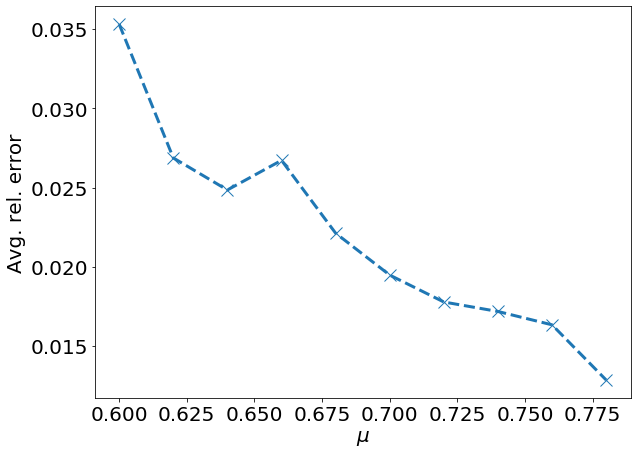

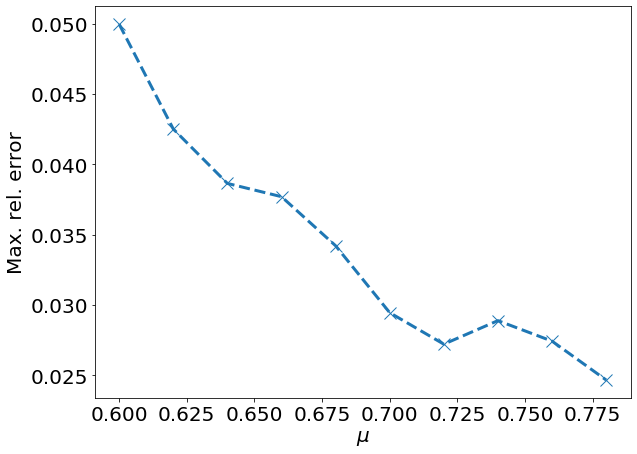

In [8]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(1.5*6.4, 1.5*4.8))
plt.plot(ampArr,1e-2*resultArr[:,-2],'x--',linewidth=3,markersize=12)
plt.xlabel(r'$\mu$')
plt.ylabel('Avg. rel. error')
plt.show()

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(1.5*6.4, 1.5*4.8))
plt.plot(ampArr,1e-2*resultArr[:,-1],'x--',linewidth=3,markersize=12)
plt.xlabel(r'$\mu$')
plt.ylabel('Max. rel. error')
plt.show()

In [9]:
print('NM-LSPG-HR')
print()
ampArr = resultArr[:,0]
namp=ampArr.shape[0]
print('{:^6}\t{:^10}\t{:^10}\t{:^12}\t{:^12}\t{:^12}'.format('param','basis_dim','num_sample','time_elapsed','avg_rel_err','max_rel_err'))
for iii in range(namp):
    amp=ampArr[iii]
    basis_dim=int(resultArr[iii,1])
    num_sample=int(resultArr[iii,2])
    time_elapsed=resultArr[iii,3]
    avg_rel_err=resultArr[iii,4]
    max_rel_err=resultArr[iii,5]
    
    print('{:^6.2f}\t{:^10d}\t{:^10d}\t{:^12.2f}\t{:^12.2f}\t{:^12.2f}'.format(amp,basis_dim,num_sample,time_elapsed,avg_rel_err,max_rel_err))

NM-LSPG-HR

param 	basis_dim 	num_sample	time_elapsed	avg_rel_err 	max_rel_err 
 0.60 	    46    	    48    	    0.60    	    3.53    	    5.00    
 0.62 	    37    	    39    	    0.60    	    2.69    	    4.25    
 0.64 	    37    	    39    	    0.62    	    2.49    	    3.86    
 0.66 	    44    	    46    	    0.67    	    2.67    	    3.77    
 0.68 	    42    	    44    	    0.62    	    2.21    	    3.42    
 0.70 	    42    	    44    	    0.62    	    1.95    	    2.95    
 0.72 	    42    	    44    	    0.59    	    1.78    	    2.72    
 0.74 	    42    	    44    	    0.63    	    1.72    	    2.89    
 0.76 	    43    	    45    	    0.67    	    1.63    	    2.74    
 0.78 	    36    	    45    	    0.65    	    1.29    	    2.47    


# Save

In [10]:
pickle.dump(resultArr,open('./data/prediction_NM-LSPG-HR.p','wb'))
savemat('./data/prediction_NM-LSPG-HR.mat',{'resultArr':resultArr})